# ECG classification

Laurent Cetinsoy - Datadidacte


In [81]:
from IPython.display import HTML
import librosa
import collections
import tensorflow as tf

import pywt
from sklearn.preprocessing import StandardScaler
from scipy.stats import entropy
import pandas as pd

from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
import matplotlib.pyplot as plt

## A first naive model by extracting simple features


Your environment contains variables arr, nsr, and chf which respectively contain 10-second recordings of ECG signals extracted from three datasets on PhysioNet: one from a person suffering from arrhythmia, one from a person with a normal heart rhythm, and another from a person with heart failure.


Matplotlib  subplots (or any other library), display these signals on three subfigures (the subplots should be called with the parameter nrows = 3).
Can you find any differences between them?

In [18]:
import numpy as np

arr = np.loadtxt('arr.txt')
chf = np.loadtxt('chf.txt')
nsr = np.loadtxt('nsr.txt')


We want to extract features from the time series. For that we will use simple statistics.


Create a function named calculate_stats_features(x) that calculates some statistical features of a signal x using standard numpy functions: nanpercentile, nanmean, etc.
calculate_stats_features will return a list of features in this order:

0. Max
1. Min
2. Mean
3. Median
4. Variance

In [19]:
def calculate_stats_feature(x):    
    return [np.nanmax(x), np.nanmin(x), np.nanmean(x), np.nanmedian(x), np.nanvar(x)]



Create a function named `calculate_zero_crossing(x)` that calculates the Zero
Crossing of a signal x.

The zero crossing is defined as the number of times the signal changes sign.
For this, you can use the signbit, diff, and nonzero functions from numpy.


In [20]:
def calculate_zero_crossing(x):
    sign_changes = np.signbit(x)
    diff_sign = np.diff(sign_changes)
    zero_crossings = np.count_nonzero(diff_sign)
    return zero_crossings

Create a function named **calculate_rms(x)** that returns the Root Mean Square (RMS) of a signal x. We will use the nanmean function instead of the mean function from numpy.

In [21]:
def calculate_rms(x):
    return np.sqrt(np.nanmean(np.square(x)))

Create a function named calculate_entropy(x) that calculates the Shannon entropy of a signal x using the entropy function from scipy.stats.

In [22]:
def calculate_entropy(x):
    values, counts = np.unique(x, return_counts=True)
    prob_dist = counts / counts.sum()
    entropy_value = entropy(prob_dist, base=2)
    
    return entropy_value

Create a function get_features(x) that combines the features calculated by all previous functions including caculate_stats_features.

In [23]:
def get_features(x):
    
    stats_features = calculate_stats_feature(x)
    stats_features.append(calculate_zero_crossing(x))
    stats_features.append(calculate_rms(x))
    stats_features.append(calculate_entropy(x))
    
    return np.array(stats_features)
    

Load the small ecg dataset
Use your fonction get_features create a new dataframe where you have all the feature as X and y as the label.
Train a random forest on it after doing a train test split if the dataset is not too small

In [28]:
df = pd.read_csv('ECG-laurent.csv')
df

/var/folders/_t/_09rqyyj0v3g_c9sgq8sp4k40000gn/T/ipykernel_1950/843125960.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('ECG-laurent.csv')


,0,1,2,3,4,5,6,7,8,9,...,65528,65529,65530,65531,65532,65533,65534,65535,65536,65537
0,213,1,-0.060085,0.001638,-0.014941,-0.018776,-0.110048,-0.160348,-0.196445,-0.287140,...,-0.145316,-0.088612,0.001568,0.066026,0.154291,0.214976,0.227396,0.172451,0.011588,-0.154281
1,213,1,-0.467585,-0.650931,-0.595663,-0.627657,-0.552164,-0.532318,-0.500500,-0.486974,...,0.273010,0.279927,0.213876,0.137012,0.019218,-0.031818,-0.068809,-0.068333,-0.178109,-0.136239
2,207,1,-0.155555,-0.229827,-0.207653,-0.210114,-0.191253,-0.184057,-0.152477,-0.171106,...,-1.238173,-1.112138,-0.812259,-0.595419,-0.444057,-0.326833,-0.117486,-0.038309,-0.015658,0.004507
3,207,1,0.099644,0.098019,0.089555,0.108130,0.070369,0.083866,0.073525,0.061310,...,-0.291689,-0.111845,0.180895,0.373213,0.486517,0.394578,0.283331,0.169355,0.166666,0.146715
4,212,1,-0.368856,-0.530640,-0.487672,-0.447722,-0.276366,-0.292531,-0.236326,-0.209993,...,-0.546984,-0.427314,-0.527221,-0.588838,-0.624649,-0.577075,-0.652600,-0.500391,-0.386848,-0.161838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,chf12,2,0.074907,0.105856,-0.000567,-0.439990,-0.876207,-1.187291,-1.334461,-1.255440,...,-0.027454,0.002023,0.025988,0.018896,0.033075,0.050003,0.059558,0.056467,0.098536,0.089279
158,chf08,2,-0.320028,-0.404340,-0.396922,-0.409747,-0.408599,-0.397462,-0.391675,-0.345731,...,-0.235219,-0.209356,-0.203681,-0.195236,-0.203310,-0.192466,-0.200470,-0.177530,-0.195617,-0.168229
159,chf08,2,-0.117367,-0.069165,-0.072747,-0.090340,-0.095915,-0.094605,-0.138618,-0.139901,...,-0.194281,-0.188166,-0.179020,-0.201753,-0.184603,-0.185422,-0.180237,-0.187840,-0.172069,-0.171569
160,chf09,2,0.191584,0.405085,0.315481,0.218790,-0.024663,-0.169857,-0.366068,-0.493332,...,-0.203226,-0.223304,-0.226758,-0.238972,-0.218572,-0.261438,-0.243642,-0.320345,-0.296373,-0.381885


In [29]:
datas = df.iloc[:, 2:]
datas = pd.DataFrame(datas).to_numpy()
df = df.iloc[:, 1:2]

df.rename(columns={"1" : "y"}, inplace=True)
df['X'] = None

feature_list = []
for data in datas :
    feature_list.append(get_features(data))
    
X_feature = pd.DataFrame(feature_list)  

/var/folders/_t/_09rqyyj0v3g_c9sgq8sp4k40000gn/T/ipykernel_1950/3767728652.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={"1" : "y"}, inplace=True)
/var/folders/_t/_09rqyyj0v3g_c9sgq8sp4k40000gn/T/ipykernel_1950/3767728652.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['X'] = None


In [30]:
X = X_feature
y = df['y']

# Take a small subset (10% of the full data)
X_small, _, y_small, _ = train_test_split(X, y, train_size=0.1, random_state=42)

# Now split this smaller subset into train and test
X_train, X_test, y_train, y_test = train_test_split(X_small, y_small, test_size=0.2, random_state=42)

In [31]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")

Accuracy: 1.00


Now you have a first pipeline, do the same on the full dataset
Report the train and test loss

try to tweak the model hyperparameter to see if it works

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_train_pred_proba = clf.predict_proba(X_train)
y_test_pred_proba = clf.predict_proba(X_test)

train_loss = log_loss(y_train, y_train_pred_proba)
test_loss = log_loss(y_test, y_test_pred_proba)

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Train Loss (Log Loss): {train_loss:.4f}")
print(f"Test Loss (Log Loss): {test_loss:.4f}")
print(f"Train Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

Train Loss (Log Loss): 0.0855
Test Loss (Log Loss): 0.2431
Train Accuracy: 1.00
Test Accuracy: 0.88


## Fourier transform features

We want now to see if a model using only fourier transform could work.

create a function get_fourier_coefficients(ecg)

In [35]:
def get_fourier_coefficients(ecg, n_coefficients=20):
    fft_result = np.fft.fft(ecg)
    fft_result = fft_result[:n_coefficients]
    real_part = fft_result.real
    imag_part = fft_result.imag
    features = np.concatenate([real_part, imag_part])
    return features


Using this function create a dataframe df_fourrier containing the fourrier transform coefficients and the label

In [36]:
df = pd.read_csv('ECG-laurent.csv')

datas = df.iloc[:, 2:].to_numpy()
labels = df.iloc[:, 1]

fourier_features = [get_fourier_coefficients(ecg, n_coefficients=20) for ecg in datas]

df_fourier = pd.DataFrame(fourier_features)
df_fourier['label'] = labels.values

df_fourier.head()

/var/folders/_t/_09rqyyj0v3g_c9sgq8sp4k40000gn/T/ipykernel_1950/586825887.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('ECG-laurent.csv')


,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,label
0,-17599.976889,-758.813702,-93.278558,-592.319401,-305.129117,-385.483756,-791.780539,-459.654824,-1258.509759,315.708424,...,259.019479,-802.993730,515.802733,631.752566,-48.499544,-86.816673,-92.374215,-121.427423,-89.337117,1
1,-14484.396444,-1625.487534,-1115.147467,-592.487213,-554.254257,-285.183354,296.268696,-204.265852,-1635.338876,865.993022,...,712.090468,98.169533,743.834019,540.724815,371.019023,650.477304,659.724292,722.124494,315.183089,1
2,-10683.818667,385.954517,-196.939828,-224.784712,-96.282300,-673.024888,-577.757255,-508.416037,67.634488,-900.547863,...,452.045771,-602.824902,-80.833608,380.011376,31.910868,132.016497,-271.253223,-149.300160,224.742667,1
3,3536.462222,-264.551162,-298.594840,446.614788,-613.430463,-244.125989,-561.247176,402.691658,-785.782374,-201.149215,...,-812.093241,44.523408,-89.576617,-210.782327,45.826319,-236.954452,-416.225300,-184.073844,-222.929991,1
4,-9756.496000,7.358478,464.681459,-467.787635,271.644373,98.127012,95.593713,-66.534328,865.344309,-182.809107,...,92.142159,289.296922,-233.400921,-157.681651,81.472825,573.779937,-92.572111,-150.177272,-193.495854,1


Try to train a model using the Fourrier coefficient

In [38]:
X = df_fourier.drop(columns=['label'])
y = df_fourier['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy Fourier Coef: {accuracy:.2f}")

Accuracy Fourier Coef: 0.79


Try to learn a model using both fourrier coefficient and the features from the previous sections. Does it work ?

In [40]:
combined_features = pd.concat([X_feature, df_fourier.drop(columns=['label'])], axis=1)

y_combined = y

X_train, X_test, y_train, y_test = train_test_split(combined_features, y_combined, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy Combined Features: {accuracy:.2f}")

Accuracy Combined Features: 0.85


## Wavelets

We now wants to use another signal decomposition which are called wavelet. Wavelet are a multi-scale function decomposition on a familly of functions generated from what is called a mother wavelet.

Using PyWavelet make a function get_wavelet_coefficients(ecg) that returns the wavelet coefficient of a given ECG


In [ ]:
def get_wavelet_coefficients(ecg, wavelet='db4', level=4):
    coeffs = pywt.wavedec(ecg, wavelet=wavelet, level=level)
    wavelet_features = np.hstack(coeffs)
    return wavelet_features

Using the get_wavelet_coefficients, create a dataframe when the features are the coefficients and include the label

In [52]:
df = pd.read_csv('ECG-laurent.csv')

datas = df.iloc[:, 2:].to_numpy()
labels = df.iloc[:, 1]

wavelet_features = [get_wavelet_coefficients(ecg, wavelet='db4', level=4) for ecg in datas]

df_wavelet = pd.DataFrame(wavelet_features)

df_wavelet['label'] = labels.values
df_wavelet

/var/folders/_t/_09rqyyj0v3g_c9sgq8sp4k40000gn/T/ipykernel_1950/4209439223.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('ECG-laurent.csv')


,0,1,2,3,4,5,6,7,8,9,...,65553,65554,65555,65556,65557,65558,65559,65560,65561,label
0,-0.228740,-0.190008,-0.179619,-0.226580,-0.031340,-1.018605,-0.444753,-2.368966,-1.634749,-0.977731,...,0.020990,-0.037387,0.028253,0.002237,-0.000266,-0.028554,0.014615,0.031316,-0.027797,1
1,-2.284291,-2.311781,-2.299607,-2.283637,-2.467491,-1.493960,-3.442873,-4.733150,-1.800736,-0.455900,...,0.016427,0.000257,-0.018340,-0.019976,0.006214,-0.063029,0.020517,0.055184,-0.012997,1
2,-0.821863,-0.796012,-0.774485,-0.775475,-0.978186,-0.179384,-0.315090,-1.138809,-0.368271,0.456424,...,-0.109406,0.154508,0.025962,-0.032860,0.056736,-0.031413,0.009088,0.012298,-0.058915,1
3,0.348926,0.375198,0.371578,0.332356,0.535287,-0.082380,2.922918,0.238627,0.597085,1.542039,...,0.037289,0.045591,0.031034,0.009156,-0.016872,0.045184,-0.008458,-0.029453,0.015599,1
4,-1.643063,-1.666765,-1.676780,-1.630421,-1.849698,-0.928686,0.243894,-1.045281,-0.736337,-0.233167,...,0.263982,-0.425948,0.128538,-0.049629,-0.076230,-0.007552,-0.001764,0.022396,0.089177,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,-1.256411,-1.176086,-1.000601,-1.271352,-0.768256,-2.578013,0.597282,0.373866,0.595444,-1.932390,...,0.007585,-0.010335,0.009463,0.001435,0.001654,0.022055,-0.007558,-0.020769,0.006174,2
158,-1.547153,-1.558670,-1.539930,-1.546184,-1.587573,-1.424208,-1.299591,-1.291218,-1.166278,-1.821944,...,0.007847,-0.012782,-0.000983,-0.008603,-0.008715,-0.017159,0.005511,0.017860,0.006525,2
159,-0.365921,-0.357162,-0.362281,-0.369334,-0.313935,-0.525250,-0.576419,-0.590355,-0.647901,-0.987933,...,0.000326,0.000340,0.011216,0.009061,0.001568,0.008229,-0.002588,-0.008707,-0.001065,2
160,0.731175,0.785912,0.819470,0.593377,1.540172,-1.551643,-0.743050,-3.033243,-1.141369,-0.903578,...,0.016191,0.002240,0.005429,0.021204,0.028493,0.039656,-0.012011,-0.042655,-0.025372,2


Train a random forest classifier with such features. DOes the model work

In [54]:
X_wavelet = df_wavelet.drop(columns=['label'])
y_wavelet = df_wavelet['label']

X_train, X_test, y_train, y_test = train_test_split(X_wavelet, y_wavelet, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy Wavelet Features: {accuracy:.2f}")

Accuracy Wavelet Features: 0.64


Add one or several of the previous feature functions and try to train another model

In [63]:
df_fourier_combined = pd.DataFrame(fourier_features)

X_combined = pd.concat([X_feature, df_fourier_combined, df_wavelet.drop(columns=['label'])], axis=1)
y_combined = y

X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy using Wavelet, Fourier, Statistical: {accuracy:.2f}")

Accuracy using Wavelet, Fourier, Statistical: 0.61


Specify the methodology you used to train the model and report the various attempts results into a table

In [65]:
df = pd.read_csv('ECG-laurent.csv')

datas = df.iloc[:, 2:].to_numpy()
y = df.iloc[:, 1]

def train_and_evaluate(X_features, y_labels):
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.2, random_state=42)
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

X_wavelet = df_wavelet.drop(columns=['label'])
y_wavelet = y
accuracy_wavelet = train_and_evaluate(X_wavelet, y_wavelet)

X_fourier = df_fourier_combined
y_fourier = y
accuracy_fourier = train_and_evaluate(X_fourier, y_fourier)

X_statistical = X_feature
y_statistical = y
accuracy_statistical = train_and_evaluate(X_statistical, y_statistical)

X_combined_fourier_wavelet = pd.concat([df_wavelet.drop(columns=['label']), df_fourier_combined], axis=1)
accuracy_combined_fourier_wavelet = train_and_evaluate(X_combined_fourier_wavelet, y_combined)

X_combined_wavelet_statistical = pd.concat([df_wavelet.drop(columns=['label']), X_feature], axis=1)
accuracy_combined_wavelet_statistical = train_and_evaluate(X_combined_wavelet_statistical, y_combined)

X_combined = pd.concat([X_feature, df_fourier_combined, df_wavelet.drop(columns=['label'])], axis=1)
accuracy_combined_all = train_and_evaluate(X_combined, y_combined)

results = pd.DataFrame({
    'Experiment': [
        'Wavelet only',
        'Fourier only',
        'Statistical only',
        'Wavelet + Fourier',
        'Wavelet + Statistical',
        'Wavelet + Fourier + Statistical'
    ],
    'Accuracy': [
        accuracy_wavelet,
        accuracy_fourier,
        accuracy_statistical,
        accuracy_combined_fourier_wavelet,
        accuracy_combined_wavelet_statistical,
        accuracy_combined_all
    ]
})

results

/var/folders/_t/_09rqyyj0v3g_c9sgq8sp4k40000gn/T/ipykernel_1950/739754870.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('ECG-laurent.csv')


,Experiment,Accuracy
0,Wavelet only,0.636364
1,Fourier only,0.787879
2,Statistical only,0.878788
3,Wavelet + Fourier,0.575758
4,Wavelet + Statistical,0.575758
5,Wavelet + Fourier + Statistical,0.606061


## Deep learning (1D CNN)

Now we want to see if we can skip all theses feature engineering techniques !
Design and train a multi-layer one dimensional CNN using the raw ECG signal as features.


Could you reach or surpass the feature based models ?

In [ ]:
df = pd.read_csv('ECG-laurent.csv')

X = df.iloc[:, 2:].to_numpy()
y = df.iloc[:, 1].to_numpy()

X = X[..., np.newaxis]

scaler = StandardScaler()
X = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

/var/folders/_t/_09rqyyj0v3g_c9sgq8sp4k40000gn/T/ipykernel_1950/3448007457.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('ECG-laurent.csv')


In [77]:
def create_cnn_model(input_shape):
    model = models.Sequential()
    
    model.add(layers.Conv1D(16, 3, activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling1D(2))
    
    model.add(layers.Conv1D(32, 3, activation='relu'))
    model.add(layers.MaxPooling1D(2))
    
    model.add(layers.Flatten())
    
    model.add(layers.Dense(32, activation='relu'))
    
    model.add(layers.Dense(len(np.unique(y)), activation='softmax'))
    
    return model

In [86]:
model = create_cnn_model(X_train.shape[1:])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/10
9/9 [==============================] - 6s 542ms/step - loss: 11.1595 - accuracy: 0.4651 - val_loss: 4.9303 - val_accuracy: 0.5758
Epoch 2/10
9/9 [==============================] - 5s 498ms/step - loss: 1.5759 - accuracy: 0.7829 - val_loss: 1.0655 - val_accuracy: 0.6364
Epoch 3/10
9/9 [==============================] - 5s 497ms/step - loss: 0.4270 - accuracy: 0.8527 - val_loss: 0.5572 - val_accuracy: 0.7879
Epoch 4/10
9/9 [==============================] - 5s 506ms/step - loss: 0.2816 - accuracy: 0.9302 - val_loss: 1.2917 - val_accuracy: 0.7273
Epoch 5/10
9/9 [==============================] - 5s 502ms/step - loss: 0.1429 - accuracy: 0.9535 - val_loss: 0.9137 - val_accuracy: 0.7879
Epoch 6/10
9/9 [==============================] - 5s 498ms/step - loss: 0.0482 - accuracy: 0.9922 - val_loss: 0.8319 - val_accuracy: 0.7576
Epoch 7/10
9/9 [==============================] - 5s 502ms/step - loss: 0.0154 - accuracy: 1.0000 - val_loss: 0.9446 - val_accuracy: 0.7879
Epoch 8/10
9/9 [===

2/2 [==============================] - 0s 33ms/step - loss: 0.8170 - accuracy: 0.7879
Test Accuracy: 0.79


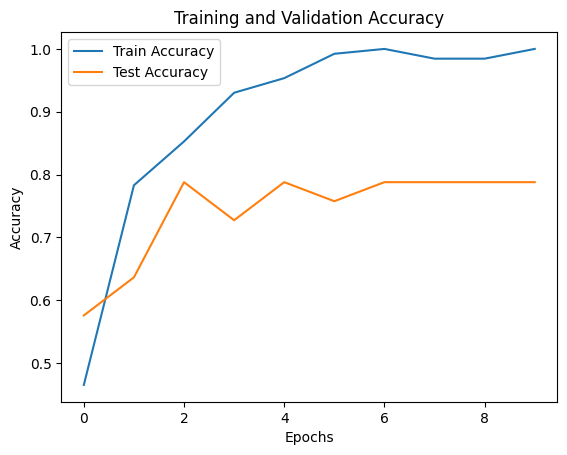

In [87]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")


plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()